# Image viewer

This notebook is for inspecting timelapse microscopy data, with associated sinhgle-cell labels and tracks, showing the infection of human macrophages with Mycobacterium Tuberculosis (Mtb), acquired on an Opera Phenix confocal microscope. 

In [1]:
import napari
import os, glob
from macrohet import dataio, tile, visualise, notify
import numpy as np
from macrohet import visualise
import os
import re
import numpy as np
import cv2
import btrack
import zarr

### Load experiment of choice

The Opera Phenix is a high-throughput confocal microscope that acquires very large 5-dimensional (TCZXY) images over several fields of view in any one experiment. Therefore, a lazy-loading approach is chosen to mosaic, view and annotate these images. This approach depends upon Dask and DaskFusion. The first step is to load the main metadata file (typically called `Index.idx.xml` and located in the main `Images` directory) that contains the image filenames and associated TCXZY information used to organise the images.

In [2]:
%%time
expt_ID = 'ND0003'

base_dir = f'/mnt/SYNO/macrohet_syno/data/{expt_ID}/'
# base_dir = f'/mnt/DATA/macrohet/{expt_ID}/'

metadata_fn = glob.glob(os.path.join(base_dir, 'acquisition/Images/Index*xml'))[0]
metadata = dataio.read_harmony_metadata(metadata_fn)  
metadata

Reading metadata XML file...


0it [00:00, ?it/s]

Extracting metadata complete!
CPU times: user 33.1 s, sys: 3 s, total: 36.1 s
Wall time: 47.6 s


,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0301K1F1P1R1,Ok,r03c01f01p01-ch1sk1fk1fl1.tiff,3,1,1,1,0,1,1,...,0,0.135256499,0,2024-02-16T17:15:25.597+00:00,640,706,40,1.1,0.2,"[[0.999464,0,0,-5.0],[0,-0.999464,0,4.1],[0,0,..."
1,0301K1F1P1R2,Ok,r03c01f01p01-ch2sk1fk1fl1.tiff,3,1,1,1,0,2,1,...,0,0.135256499,0,2024-02-16T17:15:25.813+00:00,488,522,40,1.1,0.1,"[[0.999464,0,0,-5.0],[0,-0.999464,0,4.1],[0,0,..."
2,0301K1F1P2R1,Ok,r03c01f01p02-ch1sk1fk1fl1.tiff,3,1,1,2,0,1,1,...,2E-06,0.1352586,0,2024-02-16T17:15:26.157+00:00,640,706,40,1.1,0.2,"[[0.999464,0,0,-5.0],[0,-0.999464,0,4.1],[0,0,..."
3,0301K1F1P2R2,Ok,r03c01f01p02-ch2sk1fk1fl1.tiff,3,1,1,2,0,2,1,...,2E-06,0.1352586,0,2024-02-16T17:15:26.39+00:00,488,522,40,1.1,0.1,"[[0.999464,0,0,-5.0],[0,-0.999464,0,4.1],[0,0,..."
4,0301K1F1P3R1,Ok,r03c01f01p03-ch1sk1fk1fl1.tiff,3,1,1,3,0,1,1,...,4E-06,0.135260597,0,2024-02-16T17:15:26.733+00:00,640,706,40,1.1,0.2,"[[0.999464,0,0,-5.0],[0,-0.999464,0,4.1],[0,0,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349267,0612K154F9P1R2,Ok,r06c12f09p01-ch2sk154fk1fl1.tiff,6,12,9,1,153,2,1,...,0,0.135008901,275402.773,2024-02-19T21:59:46.84+00:00,488,522,40,1.1,0.1,"[[0.999464,0,0,-5.0],[0,-0.999464,0,4.1],[0,0,..."
349268,0612K154F9P2R1,Ok,r06c12f09p02-ch1sk154fk1fl1.tiff,6,12,9,2,153,1,1,...,2E-06,0.135010898,275402.773,2024-02-19T21:59:47.183+00:00,640,706,40,1.1,0.2,"[[0.999464,0,0,-5.0],[0,-0.999464,0,4.1],[0,0,..."
349269,0612K154F9P2R2,Ok,r06c12f09p02-ch2sk154fk1fl1.tiff,6,12,9,2,153,2,1,...,2E-06,0.135010898,275402.773,2024-02-19T21:59:47.4+00:00,488,522,40,1.1,0.1,"[[0.999464,0,0,-5.0],[0,-0.999464,0,4.1],[0,0,..."
349270,0612K154F9P3R1,Ok,r06c12f09p03-ch1sk154fk1fl1.tiff,6,12,9,3,153,1,1,...,4E-06,0.135012895,275402.773,2024-02-19T21:59:47.743+00:00,640,706,40,1.1,0.2,"[[0.999464,0,0,-5.0],[0,-0.999464,0,4.1],[0,0,..."


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [3]:
metadata_path = glob.glob(os.path.join(base_dir, 'acquisition/Assaylayout/*.xml'))[0]
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,replicate_number=False)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
Row Column                                              
3   1         UNI     CTRL             0             EC0
    2         UNI     CTRL             0             EC0
    3          WT     CTRL             0             EC0
    4          WT     CTRL             0             EC0
    5          WT      PZA            60            EC50
    6          WT      PZA            60            EC50
    7          WT      RIF           0.1            EC50
    8          WT      RIF           0.1            EC50
    9          WT      INH          0.04            EC50
    10         WT      INH          0.04            EC50
    11         WT      BDQ          0.02            EC50
    12         WT      BDQ          0.02            EC50
4   3          WT     CTRL             0             EC0
    4          WT     CTRL             0             EC0
    5          WT      PZA           400            EC99
    6          WT      PZA           400            EC99
    7          WT      RIF             2            EC99
    8          WT      RIF             2            EC99
    9          WT      INH             2            EC99
    10         WT      INH             2            EC99
    11         WT      BDQ           2.5            EC99
    12         WT      BDQ           2.5            EC99
5   3         RD1     CTRL             0             EC0
    4         RD1     CTRL             0             EC0
    5         RD1      PZA            60            EC50
    6         RD1      PZA            60            EC50
    7         RD1      RIF           0.1            EC50
    8         RD1      RIF           0.1            EC50
    9         RD1      INH          0.04            EC50
    10        RD1      INH          0.04            EC50
    11        RD1      BDQ          0.02            EC50
    12        RD1      BDQ          0.02            EC50
6   3         RD1     CTRL             0             EC0
    4         RD1     CTRL             0             EC0
    5         RD1      PZA           400            EC99
    6         RD1      PZA           400            EC99
    7         RD1      RIF             2            EC99
    8         RD1      RIF             2            EC99
    9         RD1      INH             2            EC99
    10        RD1      INH             2            EC99
    11        RD1      BDQ           2.5            EC99
    12        RD1      BDQ           2.5            EC99

### Load using Zarr

In [4]:
acq_ID = (5, 3)

In [5]:
image_dir = os.path.join(base_dir, f'acquisition/zarr/{acq_ID}.zarr')

zarr_group = zarr.open(image_dir, mode='r')

In [7]:
%%time
images = zarr_group.images[:,:,:,...]
images.shape

CPU times: user 37.6 s, sys: 34 s, total: 1min 11s
Wall time: 26.2 s


(154, 2, 3, 6048, 6048)

In [6]:
images_max_proj = np.max(zarr_group.images, axis = 2)

In [7]:
images_max_proj.shape

(154, 2, 6048, 6048)

In [30]:
images.shape

(154, 2, 3, 6048, 6048)

In [9]:
viewer = napari.Viewer(title = f'{expt_ID, acq_ID}, full image stack')

viewer.add_image(images,
                 channel_axis = 1, 
                 colormap=['magenta', 'green'],
                 blending = 'additive', 
                 contrast_limits=[[350, 1000],[0, 7000]]
                )

[<Image layer 'Image' at 0x7f6f4b3c5d30>,
 <Image layer 'Image [1]' at 0x7f70fc079a00>]

In [8]:
viewer = napari.Viewer(title = f'{expt_ID, acq_ID}, max_proj')


viewer.add_image(images_max_proj,
                 channel_axis = 1, 
                 colormap=['magenta', 'green'],
                 blending = 'additive', 
                 contrast_limits=[[350, 1000],[0, 7000]]
                )

[<Image layer 'Image' at 0x7f1109705a00>,
 <Image layer 'Image [1]' at 0x7f12c2874b50>]

In [9]:
with btrack.io.HDF5FileHandler(os.path.join(f'/mnt/SYNO/macrohet_syno/data/{expt_ID}/labels/cpv3/5,3.h5'), 
                                           'r', 
                                           obj_type='obj_type_1'
                                           ) as reader:
                segmentation = reader.segmentation
                tracks = reader.tracks

[INFO][2024/07/10 03:56:15 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/data/ND0003/labels/cpv3/5,3.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/data/ND0003/labels/cpv3/5,3.h5...
[INFO][2024/07/10 03:56:36 pm] Loading segmentation (154, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (154, 6048, 6048)
[INFO][2024/07/10 03:56:36 pm] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/07/10 03:56:36 pm] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/07/10 03:56:36 pm] Loading objects/obj_type_1 (42374, 5) (42374 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (42374, 5) (42374 filtered: None)
[INFO][2024/07/10 03:56:37 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/data/ND0003/labels/cpv3/5,3.h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/data/ND0003/labels/cpv3/5,3.h5


In [35]:
import seaborn as sns

<Axes: ylabel='Count'>

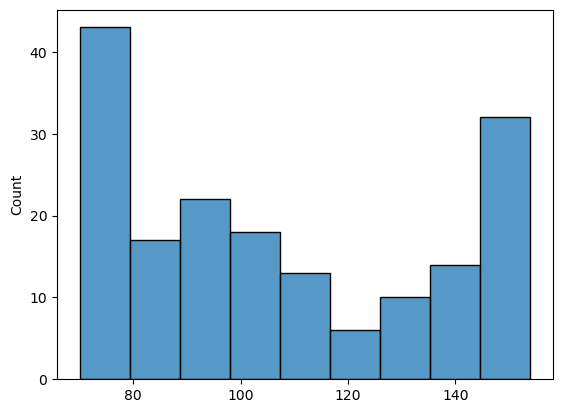

In [37]:
sns.histplot([len(t) for t in tracks if len(t) >= 70])

In [38]:
len(filtered_tracks)

175

In [26]:
filtered_tracks = [t for t in tracks if len(t) >= 70]

In [27]:
recoloured_seg = btrack.utils.update_segmentation(segmentation, filtered_tracks, scale = (5.04, 5.04))

In [28]:
viewer.add_labels(recoloured_seg)

<Labels layer 'recoloured_seg [1]' at 0x7f5f5690f0d0>

In [10]:
viewer.add_labels(segmentation)

<Labels layer 'segmentation' at 0x7f12c2fde790>

In [11]:
filtered_tracks = [track for track in tracks if len(track) > 70]

In [12]:
napari_tracks, _, _ = btrack.utils.tracks_to_napari(filtered_tracks, ndim = 2)

In [13]:
viewer.add_tracks(napari_tracks, scale=(5.04, 5.04), name = 'filtered')

<Tracks layer 'filtered' at 0x7f10febd8700>

# PIV test

In [1]:
images.shape

NameError: name 'images' is not defined

In [33]:
z0 = i

In [34]:
from skimage import io

In [39]:
t3[0,0].all()

False

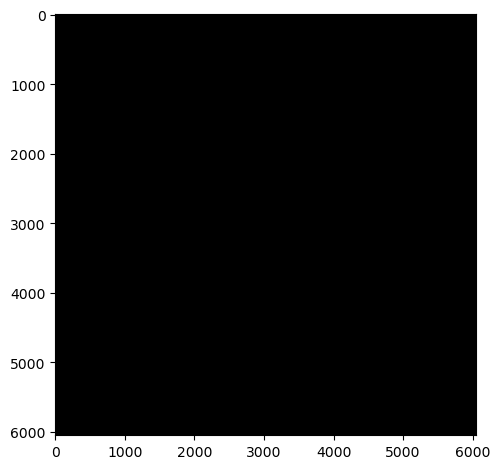

In [37]:
io.imshow(t3[0,0])